<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-обзор-данных" data-toc-modified-id="Загрузка-и-обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и обзор данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Подготовка-данных-для-обучения-моделей" data-toc-modified-id="Подготовка-данных-для-обучения-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка данных для обучения моделей</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#DecisionTreeClassifier" data-toc-modified-id="DecisionTreeClassifier-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>DecisionTreeClassifier</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li><li><span><a href="#PassiveAggressiveClassifier" data-toc-modified-id="PassiveAggressiveClassifier-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>PassiveAggressiveClassifier</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Итоговые-выводы" data-toc-modified-id="Итоговые-выводы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Итоговые выводы</a></span></li></ul></div>

# Определение токсичных комментариев для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис - теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах, т.е. клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

**Цель исследования:** построение модели для классификации комментариев на позитивные и негативные.

Компания собрала и предоставила набор данных с разметкой о токсичности правок.

**Заказчику важен следующий показатель:** значение метрики *F1* не меньше 0.75.

**Этапы исследования:**
1. Загрузка и обзор данных
2. Анализ данных
3. Подготовка данных для обучения моделей
4. Обучение моделей
5. Анализ моделей
6. Написание общего вывода

## Загрузка и обзор данных

Установим и импортируем необходимые для исследования библиотеки:

In [1]:
!pip install wordcloud==1.8.2.2 -q
!pip install Pillow==9.5.0 -q

In [2]:
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import notebook
from tqdm.auto import tqdm
from pymystem3 import Mystem
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import time
from wordcloud import WordCloud
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

Определим переменные:

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

Отключим отображение предупреждений:

In [4]:
warnings.filterwarnings('ignore')

Откроем файл с датасетом:

In [5]:
try:
    toxic_comments = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
except:
    toxic_comments = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=0)

Выведем первые строки и общую информацию о датафрейме `toxic_comments`:

In [6]:
toxic_comments.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Датафрейм содержит следующие данные:
* `text` - текст комментария
* `toxic` - целевой признак

Выведем информацию о датафрейме `toxic_comments`:

In [7]:
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


В нашем распоряжении набор данных с комментариями и признаком их токсичности.

## Анализ данных

Проверим данные на наличие пропусков и явных дубликатов:

In [8]:
print('Количество пропусков данных:')
for i in toxic_comments.items():
    print(f'- столбец "{i[0]}": {toxic_comments[i[0]].isna().sum()}')
print(f'Количество явных дубликатов: {toxic_comments.duplicated().sum()}')

Количество пропусков данных:
- столбец "text": 0
- столбец "toxic": 0
Количество явных дубликатов: 0


Пропусков данных и явных дубликатов в датафрейме не обнаружено. 

Определим распределение классов целевого признака `toxic`:

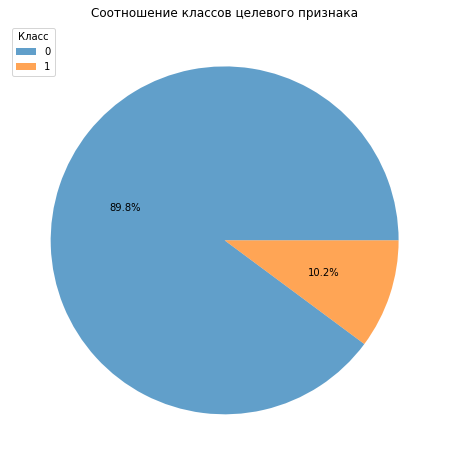

In [9]:
plt.figure(figsize=(14, 8))
toxic_comments['toxic'].value_counts().plot(
    kind='pie',
    ylabel='',
    title='Соотношение классов целевого признака',
    autopct='%1.1f%%',
    wedgeprops={'alpha': 0.7},
    labels=None
)
plt.legend(
    title='Класс',
    loc='upper left',
    labels=['0', '1']
);

В датафрейме присутствует явный дисбаланс классов целевого признака, т.к. класс 1 имеет долю всего 10.2% против 89.8% доли класса 0. Данный факт стоит учитывать при делении датафрейма на обучающие и тестовые выборки.

Посчитаем количество слов в твите в разбивке по целевому признаку. Определим функцию для подсчета слов:

In [10]:
def words_number(text):
    return len(text.split())

Добавим столбец с количеством слов в датафрейм:

In [11]:
%%time
tqdm.pandas()
toxic_comments['words_number'] = toxic_comments['text'].progress_apply(words_number)
toxic_comments.head()

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: user 830 ms, sys: 18.3 ms, total: 848 ms
Wall time: 895 ms


,text,toxic,words_number
0,Explanation\nWhy the edits made under my usern...,0,43
1,D'aww! He matches this background colour I'm s...,0,17
2,"Hey man, I'm really not trying to edit war. It...",0,42
3,"""\nMore\nI can't make any real suggestions on ...",0,113
4,"You, sir, are my hero. Any chance you remember...",0,13


In [12]:
def show_graph(data, column, hue, hist_title_1, hist_title_2, box_title, xlabel, ylabel):
    fig, axes = plt.subplots(3, 1, figsize=(16, 25))
    histplot_1 = sns.histplot(
        data=data,
        x=column,
        hue=hue,
        bins=50,
        color='darkcyan',
        kde=True,
        ax=axes[0]
    )
    histplot_1.set(
        title=hist_title_1,
        xlabel=xlabel,
        ylabel='Количество'
    )
    histplot_2 = sns.histplot(
        data=data,
        x=column,
        hue=hue,
        stat='density',
        common_norm=False,
        kde=True,
        ax=axes[1]
    )
    histplot_2.set(
        title=hist_title_2,
        xlabel=xlabel,
        ylabel='Плотность распределения'
    )
    boxplot = sns.boxplot(
        data=data,
        x=column,
        y=hue,
        color='salmon',
        orient='h',
        ax=axes[2]
    )
    boxplot.set(
        title=box_title,
        xlabel=xlabel,
        ylabel=ylabel
    )

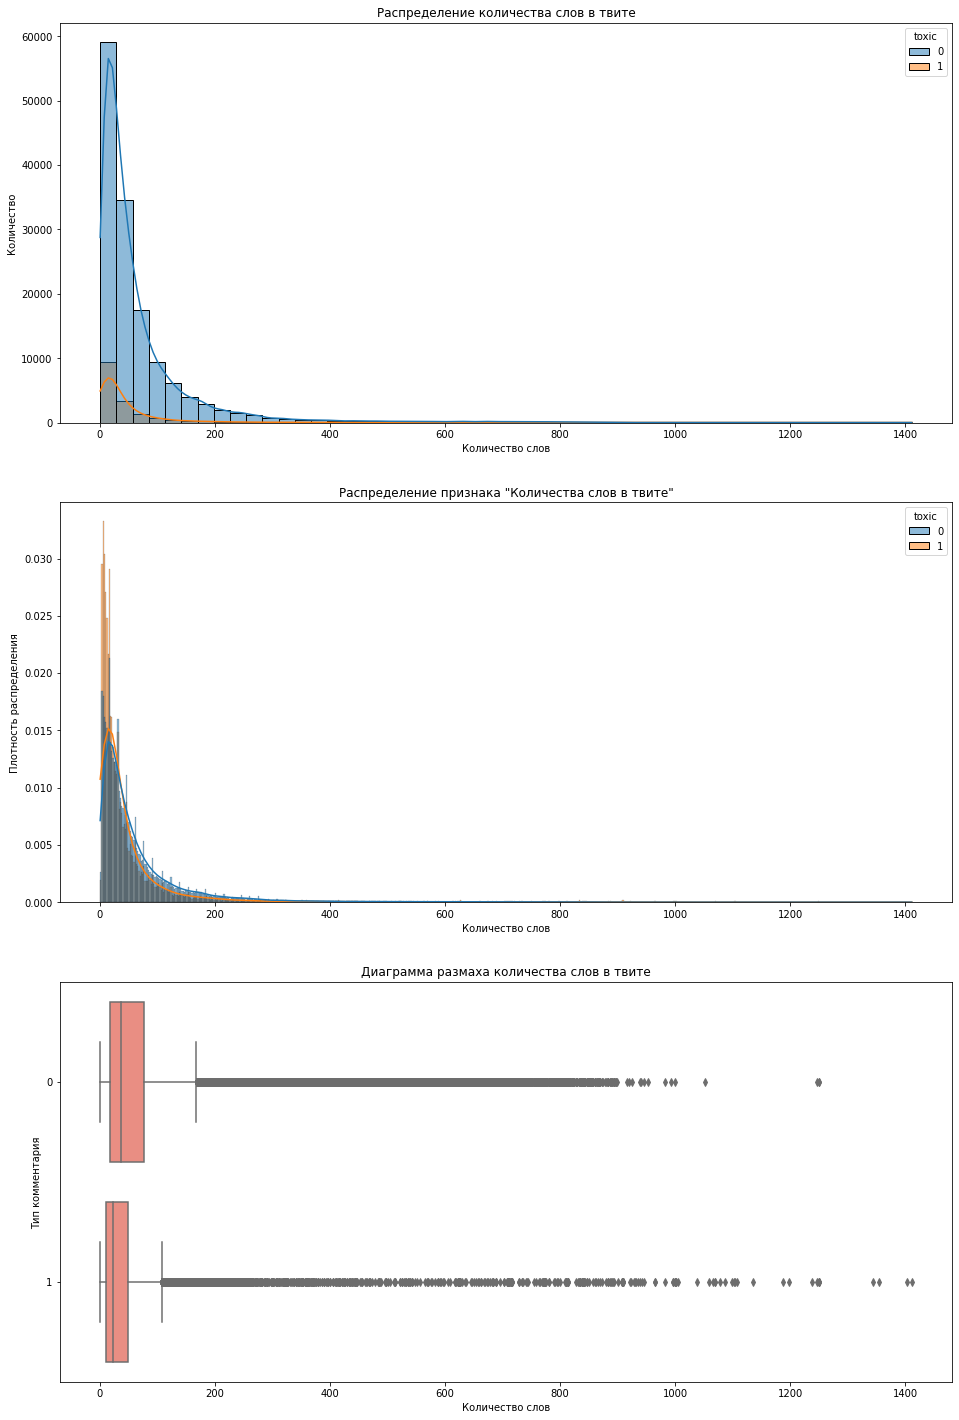

In [13]:
show_graph(
    toxic_comments,
    'words_number',
    'toxic',
    'Распределение количества слов в твите',
    'Распределение признака "Количества слов в твите"',
    'Диаграмма размаха количества слов в твите',
    'Количество слов',
    'Тип комментария'
)

Большинство комментариев состоят из менее чем 100 слов. Т.к. анализ проводится по двум выборкам разного размера - для анализа их распределения была использована нормированная гистограмма (гистограммы такого типа позволяют нивелировать разницу в размерах выборок при анализе распределений). По такой диаграмме видно, что, "немногословных" токсичных комментариев (менее 50 слов) больше, чем аналогичных, но не токсичных. С увеличением количества слов не токсичных комментариев становится больше, чем токсичных. В целом, боьшинство комментариев состоят не более чем из 100 слов.

## Подготовка данных для обучения моделей

В тексте комментариев присутствуют знаки препинания, переносы строк, заглавные буквы. Произведем предобработку текста путем токенизации и лемматизации, для этого определим функции:

In [14]:
def clear_text(text):
    return ' '.join(re.sub(r'[^а-яА-ЯёЁa-zA-Z]', ' ', text).split()).lower()

In [15]:
m = Mystem()

In [16]:
def lemmatize(text):
    return ''.join(m.lemmatize(clear_text(text)))

Проверим работу функций на тексте первого комментария:

In [17]:
comment = toxic_comments['text'].loc[0]
print(f'Исходный текст: {comment}')
print(50 * '-')
print(f'Очищенный и лемматизированный текст: {lemmatize(comment)}')

Исходный текст: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
--------------------------------------------------
Очищенный и лемматизированный текст: explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now



Добавим очищенный и лемматизированный текст комментариев в исходный датафрейм:

In [18]:
%%time
tqdm.pandas()
toxic_comments['lemm_text'] = toxic_comments['text'].progress_apply(lemmatize)
toxic_comments.head()

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: user 27.8 s, sys: 2.84 s, total: 30.7 s
Wall time: 1min 13s


,text,toxic,words_number,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,43,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,17,d aww he matches this background colour i m se...
2,"Hey man, I'm really not trying to edit war. It...",0,42,hey man i m really not trying to edit war it s...
3,"""\nMore\nI can't make any real suggestions on ...",0,113,more i can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,13,you sir are my hero any chance you remember wh...


Также для сравнения произведем лемматизацию с помощью WordNetLemmatizer:

In [19]:
lemmatizer = WordNetLemmatizer()

In [20]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [21]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [22]:
def wn_lemmatize(text):
    return ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(clear_text(text))])

Проверим работу функции на тексте первого комментария:

In [23]:
print(f'Исходный текст: {comment}')
print(50 * '-')
print(f'Очищенный и лемматизированный текст: {wn_lemmatize(comment)}')

Исходный текст: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
--------------------------------------------------
Очищенный и лемматизированный текст: explanation why the edits make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after i vote at new york doll fac and please don t remove the template from the talk page since i m retire now


Заметно, что лемматизацию с помощью WordNetLemmatizer работает лучше, чем Mystem.

Добавим очищенный и лемматизированный текст комментариев в исходный датафрейм:

In [24]:
%%time
tqdm.pandas()
toxic_comments['wn_lemm_text'] = toxic_comments['text'].progress_apply(wn_lemmatize)
toxic_comments.head()

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: user 18min 20s, sys: 1min 35s, total: 19min 56s
Wall time: 20min 25s


,text,toxic,words_number,lemm_text,wn_lemm_text
0,Explanation\nWhy the edits made under my usern...,0,43,explanation why the edits made under my userna...,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,17,d aww he matches this background colour i m se...,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,42,hey man i m really not trying to edit war it s...,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,113,more i can t make any real suggestions on impr...,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,13,you sir are my hero any chance you remember wh...,you sir be my hero any chance you remember wha...


Далее для обучения моделей будем использовать лемматизированный с помощью WordNetLemmatizer текст.

Проведем частотный анализ текста. Для этого воспользуемся облаком слов, чтобы получить общее представление о тематике и о наиболее часто встречаемых словах в токсичных и нетоксичных твитах (в облаке уже автоматически будут убраны стоп слова):

In [25]:
def show_wordcloud(text, title):
    wordcloud = WordCloud(
        width=2000,
        height=1500
    ).generate(text)
    plt.figure(figsize=(16, 10))
    plt.title(title)
    plt.imshow(wordcloud)
    plt.axis('off')

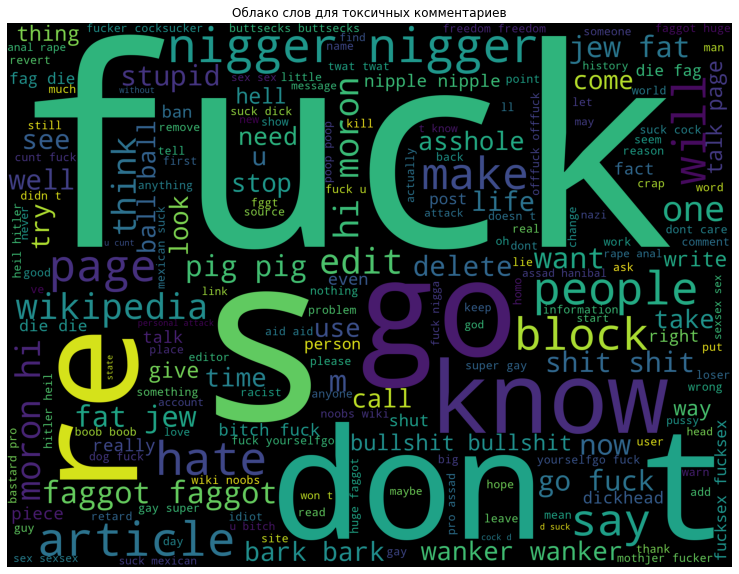

In [26]:
toxic_text = ' '.join(list(map(str, toxic_comments.loc[toxic_comments['toxic'] == 1, 'wn_lemm_text'].tolist())))
show_wordcloud(toxic_text, 'Облако слов для токсичных комментариев')

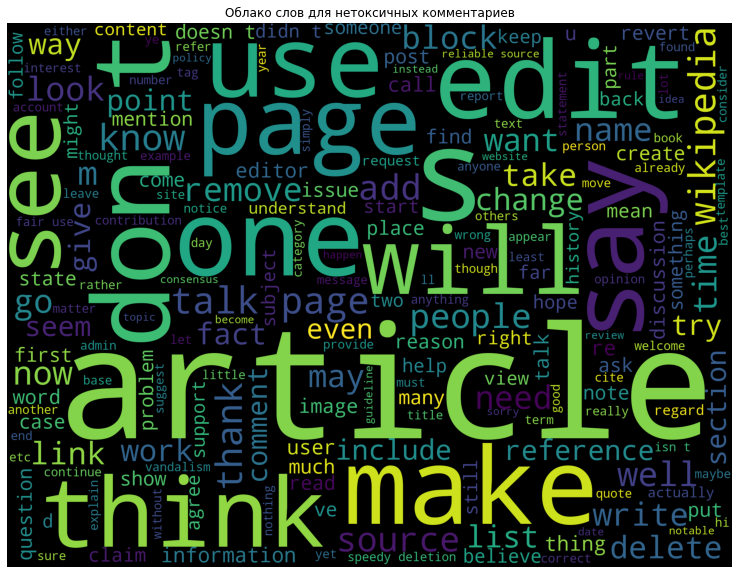

In [27]:
toxic_text = ' '.join(list(map(str, toxic_comments.loc[toxic_comments['toxic'] == 0, 'wn_lemm_text'].tolist())))
show_wordcloud(toxic_text, 'Облако слов для нетоксичных комментариев')

Сформируем тренировочные и тестовые выборки:

In [28]:
X = toxic_comments['wn_lemm_text']
y = toxic_comments['toxic']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (119469,)
X_test: (39823,)
y_train: (119469,)
y_test: (39823,)


Данные подготовлены для обучения моделей.

Определим список стоп-слов:

In [29]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Обучение моделей

С помощью пайплайнов обучим следующие модели:
* Модель LogisticRegression (логистическая регрессия)
* Модель DecisionTreeClassifier (дерево решений)
* Модель CatBoostClassifier (градиентный бустинг)
* Модель PassiveAggressiveClassifier (пассивно-агрессивный алгоритм)

В пайплайне создадим счетчик, указав в нем стоп-слова, и матрицы cо значениями `TF-IDF` по комментариям для обучающей и тестовой выборок:

In [30]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 1))),
    ('model', LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced'))
])

### LogisticRegression

Обучим модель логистической регрессии и посчитаем метрику *F1*:

In [31]:
lr_pipe_params = [
    {
        'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
        'model': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')],
        'model__C': [5, 10, 20]
    }
]

In [32]:
%%time

lr_rs = RandomizedSearchCV(
    pipe, 
    lr_pipe_params, 
    cv=3,
    n_jobs=-1,
    verbose=3,
    scoring='f1',
    random_state=RANDOM_STATE
)

lr_rs.fit(X_train, y_train)
lr_cv_f1 = lr_rs.best_score_
lr_train_time = lr_rs.cv_results_['mean_fit_time'].mean()

print(f'Лучшая модель и ее параметры:\n\n {lr_rs.best_estimator_}')
print(f'Метрика F1 лучшей модели на кросс-валидации: {lr_cv_f1}')
print(f'Среднее время обучения: {lr_train_time} сек.')

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END model=LogisticRegression(class_weight='balanced', random_state=42), model__C=5, vectorizer__ngram_range=(1, 1); total time=  44.3s
[CV 2/3] END model=LogisticRegression(class_weight='balanced', random_state=42), model__C=5, vectorizer__ngram_range=(1, 1); total time=  43.0s
[CV 3/3] END model=LogisticRegression(class_weight='balanced', random_state=42), model__C=5, vectorizer__ngram_range=(1, 1); total time=  43.7s
[CV 1/3] END model=LogisticRegression(class_weight='balanced', random_state=42), model__C=5, vectorizer__ngram_range=(1, 2); total time= 2.1min
[CV 2/3] END model=LogisticRegression(class_weight='balanced', random_state=42), model__C=5, vectorizer__ngram_range=(1, 2); total time= 2.0min
[CV 3/3] END model=LogisticRegression(class_weight='balanced', random_state=42), model__C=5, vectorizer__ngram_range=(1, 2); total time= 2.1min
[CV 1/3] END model=LogisticRegression(class_weight='balanced', random_state=

### DecisionTreeClassifier

Обучим модель дерева решений и посчитаем метрику *F1*:

In [33]:
dtc_pipe_params = [
    {
        'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': range(2, 150),
        'model__max_features': range(2, 50),
        'model__min_samples_leaf': range(1, 60),
        'model__min_samples_split': range(2, 60)
    }
]

In [34]:
%%time

dtc_rs = RandomizedSearchCV(
    pipe, 
    dtc_pipe_params, 
    cv=3,
    n_jobs=-1,
    verbose=3,
    scoring='f1',
    random_state=RANDOM_STATE
)

dtc_rs.fit(X_train, y_train)
dtc_cv_f1 = dtc_rs.best_score_
dtc_train_time = dtc_rs.cv_results_['mean_fit_time'].mean()

print(f'Лучшая модель и ее параметры:\n\n {dtc_rs.best_estimator_}')
print(f'Метрика F1 лучшей модели на кросс-валидации: {dtc_cv_f1}')
print(f'Среднее время обучения: {dtc_train_time} сек.')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END model=DecisionTreeClassifier(random_state=42), model__max_depth=135, model__max_features=16, model__min_samples_leaf=6, model__min_samples_split=45, vectorizer__ngram_range=(1, 1); total time=   5.4s
[CV 2/3] END model=DecisionTreeClassifier(random_state=42), model__max_depth=135, model__max_features=16, model__min_samples_leaf=6, model__min_samples_split=45, vectorizer__ngram_range=(1, 1); total time=   5.5s
[CV 3/3] END model=DecisionTreeClassifier(random_state=42), model__max_depth=135, model__max_features=16, model__min_samples_leaf=6, model__min_samples_split=45, vectorizer__ngram_range=(1, 1); total time=   5.5s
[CV 1/3] END model=DecisionTreeClassifier(random_state=42), model__max_depth=117, model__max_features=10, model__min_samples_leaf=27, model__min_samples_split=23, vectorizer__ngram_range=(1, 2); total time=  18.1s
[CV 2/3] END model=DecisionTreeClassifier(random_state=42), model__max_depth=117, mode

### CatBoostClassifier

Обучим модель градиентного бустинга и посчитаем метрику *F1*:

In [35]:
cbc_pipe_params = [
    {
        'vectorizer__ngram_range': [(1, 1)],
        'model': [CatBoostClassifier(random_seed=RANDOM_STATE, iterations=10, auto_class_weights='Balanced')],
        'model__depth': range(3, 5)
    }
]

In [36]:
%%time

cbc_rs = RandomizedSearchCV(
    pipe, 
    cbc_pipe_params, 
    cv=3,
    n_jobs=-1,
    verbose=3,
    scoring='f1',
    random_state=RANDOM_STATE
)

cbc_rs.fit(X_train, y_train)
cbc_cv_f1 = cbc_rs.best_score_
cbc_train_time = cbc_rs.cv_results_['mean_fit_time'].mean()

print(f'Лучшая модель и ее параметры:\n\n {cbc_rs.best_estimator_}')
print(f'Метрика F1 лучшей модели на кросс-валидации: {cbc_cv_f1}')
print(f'Среднее время обучения: {cbc_train_time} сек.')

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Learning rate set to 0.5
0:	learn: 0.5827210	total: 722ms	remaining: 6.5s
1:	learn: 0.5447065	total: 1.4s	remaining: 5.6s
2:	learn: 0.5246363	total: 2.1s	remaining: 4.91s
3:	learn: 0.5112969	total: 2.77s	remaining: 4.15s
4:	learn: 0.4985260	total: 3.42s	remaining: 3.42s
5:	learn: 0.4859913	total: 4.08s	remaining: 2.72s
6:	learn: 0.4719582	total: 4.74s	remaining: 2.03s
7:	learn: 0.4628257	total: 5.39s	remaining: 1.35s
8:	learn: 0.4546574	total: 6.06s	remaining: 673ms
9:	learn: 0.4476792	total: 6.73s	remaining: 0us
[CV 1/3] END model=<catboost.core.CatBoostClassifier object at 0x7f78d4ec1610>, model__depth=3, vectorizer__ngram_range=(1, 1); total time=  30.1s
Learning rate set to 0.5
0:	learn: 0.5829437	total: 659ms	remaining: 5.93s
1:	learn: 0.5480060	total: 1.33s	remaining: 5.32s
2:	learn: 0.5260508	total: 2.03s	remaining: 4.74s
3:	learn: 0.5106531	total: 2.67s	remaining: 4.01s
4:	learn: 0.4980777	total: 3.32s	remaining: 3.32s


### PassiveAggressiveClassifier

Обучим модель пассивно-агрессивныго алгоритма и посчитаем метрику *F1*:

In [37]:
pac_pipe_params = [
    {
        'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
        'model': [PassiveAggressiveClassifier(max_iter=50, random_state=RANDOM_STATE, class_weight='balanced')],
        'model__C': [1, 5, 10]
    }
]

In [38]:
%%time

pac_rs = RandomizedSearchCV(
    pipe, 
    pac_pipe_params, 
    cv=3,
    n_jobs=-1,
    verbose=3,
    scoring='f1',
    random_state=RANDOM_STATE
)

pac_rs.fit(X_train, y_train)
pac_cv_f1 = pac_rs.best_score_
pac_train_time = pac_rs.cv_results_['mean_fit_time'].mean()

print(f'Лучшая модель и ее параметры:\n\n {pac_rs.best_estimator_}')
print(f'Метрика F1 лучшей модели на кросс-валидации: {pac_cv_f1}')
print(f'Среднее время обучения: {pac_train_time} сек.')

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END model=PassiveAggressiveClassifier(class_weight='balanced', max_iter=50,
                            random_state=42), model__C=1, vectorizer__ngram_range=(1, 1); total time=   6.2s
[CV 2/3] END model=PassiveAggressiveClassifier(class_weight='balanced', max_iter=50,
                            random_state=42), model__C=1, vectorizer__ngram_range=(1, 1); total time=   6.0s
[CV 3/3] END model=PassiveAggressiveClassifier(class_weight='balanced', max_iter=50,
                            random_state=42), model__C=1, vectorizer__ngram_range=(1, 1); total time=   5.9s
[CV 1/3] END model=PassiveAggressiveClassifier(class_weight='balanced', max_iter=50,
                            random_state=42), model__C=1, vectorizer__ngram_range=(1, 2); total time=  18.0s
[CV 2/3] END model=PassiveAggressiveClassifier(class_weight='balanced', max_iter=50,
                            random_state=42), model__C=1, vectorizer__ngram_ran

## Анализ моделей

Сведем все полученные показатели по моделям в одной таблице:

In [40]:
compare_table = pd.DataFrame({
    'Модель': [
        'LogisticRegression',
        'DecisionTreeClassifier',
        'CatBoostClassifier',
        'PassiveAggressiveClassifier'
    ],
    'Метрика F1 на кросс-валидации': [lr_cv_f1, dtc_cv_f1, cbc_cv_f1, pac_cv_f1],
    'Среднее время обучения': [lr_train_time, dtc_train_time, cbc_train_time, pac_train_time]
})
compare_table

,Модель,Метрика F1 на кросс-валидации,Среднее время обучения
0,LogisticRegression,0.779940,91.531753
1,DecisionTreeClassifier,0.032747,10.395298
2,CatBoostClassifier,0.638733,28.988342
3,PassiveAggressiveClassifier,0.775120,10.231303


На основе полученных на кросс-валидации метрик можно сделать вывод, что модель DecisionTreeClassifier и проигрывает остальным моделям. Модель с бустингом CatBoostClassifier не дотянула до нормативного показателя метрики F1. LogisticRegression и PassiveAggressiveClassifier показали лучшую точность прогноза, причем модель PassiveAggressiveClassifier оказалась достаточно быстрой. В итоге все же предпочтение стоит отдать модели LogisticRegression, т.к. значение метрики *F1* у нее самое высокое по сравнению с остальными моделями.

Посчитаем метрику *F1* лучшей модели на тестовой выборке:

In [41]:
print(f'Метрика F1 модели LogisticRegression на тестовой выборке: {f1_score(y_test, lr_rs.best_estimator_.predict(X_test))}')

Метрика F1 модели LogisticRegression на тестовой выборке: 0.7866004962779156


Метрика *F1* на тестовой выборке находится в рамках допустимого заказчиком - больше 0.75.

Посмотрим, какие слова является наиболее важными для классификации с точки зрения модели. 

Получим список слов:

In [44]:
words = lr_rs.best_estimator_.named_steps['vectorizer'].get_feature_names()

Получим коэффициенты важности для логистической регрессии:

In [45]:
weights = lr_rs.best_estimator_.named_steps['model'].coef_[0]

Объединим в датафрем:

In [54]:
importance_table = pd.DataFrame({
    'words': words,
    'weights': weights
})
importance_table.head()

,words,weights
0,aa,-0.437679
1,aa aa,-0.023133
2,aa aat,-0.000707
3,aa accord,-0.011420
4,aa accuse,-0.002187


Определим функцию для отображения столбиковой диаграммы:

In [85]:
def show_importance(data, x, y, title, xlabel):
    plt.figure(figsize=(14, 8))
    barplot = sns.barplot(
        data=data,
        x=x,
        y=y,
        palette='hls'
    )
    barplot.set(
        title=title,
        xlabel=xlabel,
        ylabel='Вес'
    )

Выведем на графике топ-20 наиболее важных для классификации слов с точки зрения модели LogisticRegression:

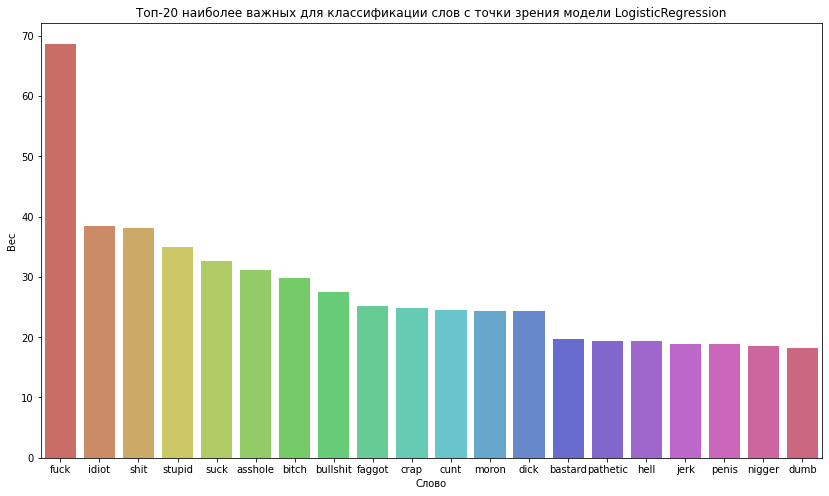

In [86]:
show_importance(
    importance_table.sort_values(by='weights', ascending=False).head(20),
    'words',
    'weights',
    'Топ-20 наиболее важных для классификации слов с точки зрения модели LogisticRegression',
    'Слово'
)

Выведем на графике топ-20 наименее важных для классификации слов с точки зрения модели LogisticRegression:

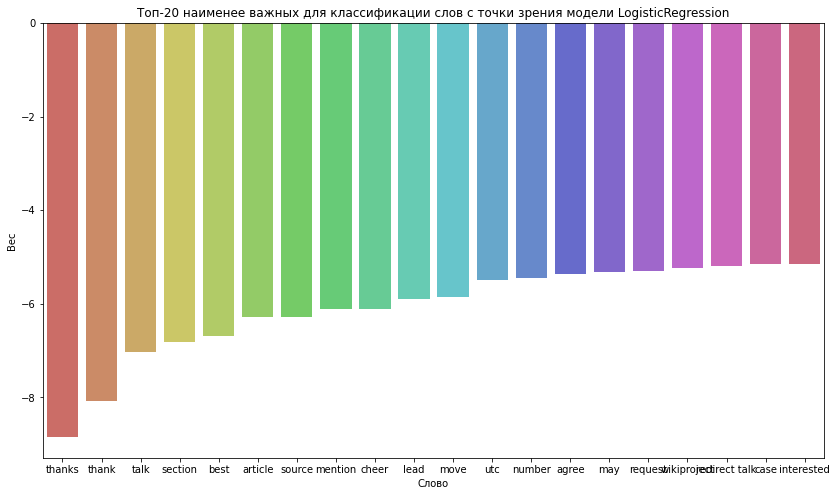

In [88]:
show_importance(
    importance_table.sort_values(by='weights').head(20),
    'words',
    'weights',
    'Топ-20 наименее важных для классификации слов с точки зрения модели LogisticRegression',
    'Слово'
)

Как видно из графиков, модель точно определяет, наличие каких слов в комментарии делает его токсичным или, наоборот, не токсичным.

## Итоговые выводы

В рамках исследования было необходимо проанализировать набор данных с разметкой о токсичности правок, предоставленные интрнет-магазином «Викишоп». Цель бизнеса - запуск нового сервиса, с помощью которого пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах, т.е. клиенты предлагают свои правки и комментируют изменения других.

В рамках исследования было необходимо решить следующие задачи:
* Построить несколько моделей машинного обучения для классификации комментариев на позитивные и негативные.
* На основе заданного заказчиком порогового значения метрики *F1* на тестовой выборке (не больше 0.75) выбрать подходящую модель.

В ходе исследования при решении данных задач были реализованы следующие этапы:
* Загрузка и обзор данных
* Анализ данных
* Подготовка данных для обучения моделей
* Обучение четырех моделей
* Анализ моделей

Опираясь на условия выбора моделей, предоставленные бизнесом, и на результаты исследования, компании «Викишоп» из четырех представленных моделей стоит выбрать LogisticRegression, т.к. она обеспечивает наиболее точный прогноз, не превышающий заданного заказчиком порогового значение метрики *F1*.